In [1]:
%matplotlib notebook

%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import sys
sys.path.insert(0,"/Users/danakoeppe/PipelineProjects/SAMOS_DRP/SAMOS_Draft/")

import os

In [3]:
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
from PIPELINE.convenience_functions import show_image

from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import importlib
import collections

import ccdproc


from itertools import groupby

from PIL import Image as P

#general os
import os
import zipfile
import urllib.request

#general plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

#table/math handling
import pandas as pd
import numpy as np
np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc

#astropy
import astropy
import astropy.units as u
from astropy.table import QTable
from astropy.io import fits,ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support,astropy_mpl_style, simple_norm
from astropy import constants as const
from astropy.stats import mad_std, sigma_clip
from astropy.nddata import CCDData
from astropy.visualization import hist
from PIPELINE.convenience_functions import show_image, display_cosmic_rays
from astropy.coordinates import SkyCoord
#specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import gaussian_smooth
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_derivative
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils.analysis import centroid
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import template_comparison

quantity_support();  # auto-recognizes units on matplotlib plots

from ipywidgets import interact
import ipywidgets as widgets

In [51]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.
    
    Parameters
    ----------
    
    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.
    
    dark_exposure_times : list
        Exposure times for which there are darks.
    
    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.
    
    Returns
    -------
    
    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and 
        np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):
        
        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, a_flat.header['exptime']))
        
    
    return closest_dark_exposure




def plot_dark_with_distributions(image, rn, dark_rate, 
                                 n_images=1,
                                 exposure=1,
                                 gain=1,
                                 show_poisson=True, 
                                 show_gaussian=True):
    """
    Plot the distribution of dark pixel values, optionally overplotting the expected Poisson and
    normal distributions corresponding to dark current only or read noise only.
    
    Parameters
    ----------
    
    image : numpy array
        Dark frame to histogram.
    
    rn : float
        The read noise, in electrons.
        
    dark_rate : float
        The dark current in electrons/sec/pixel.
    
    n_images : float, optional
        If the image is formed from the average of some number of dark frames then 
        the resulting Poisson distribution depends on the number of images, as does the 
        expected standard deviation of the Gaussian.
        
    exposure : float
        Exposure time, in seconds.
        
    gain : float, optional
        Gain of the camera, in electron/ADU.
        
    show_poisson : bool, optional
        If ``True``, overplot a Poisson distribution with mean equal to the expected dark
        counts for the number of images.
    
    show_gaussian : bool, optional
        If ``True``, overplot a normal distribution with mean equal to the expected dark
        counts and standard deviation equal to the read noise, scaled as appropiate for 
        the number of images.
    """
    
    h = plt.hist(image.flatten(), bins=20, align='mid', 
                 density=True, label="Dark frame");

    bins = h[1]
    
    expected_mean_dark = dark_rate * exposure / gain
    
    pois = stats.poisson(expected_mean_dark * n_images)

    pois_x = np.arange(0, 300, 1)

    new_area = np.sum(1/n_images * pois.pmf(pois_x))

    if show_poisson:
        plt.plot(pois_x / n_images, pois.pmf(pois_x) / new_area, 
                 label="Poisson dsitribution, mean of {:5.2f} counts".format(expected_mean_dark)) 

    if show_gaussian:
        # The expected width of the Gaussian depends on the number of images.
        expected_scale = rn / gain * np.sqrt(n_images)
        
        # Mean value is same as for the Poisson distribution 
        expected_mean = expected_mean_dark * n_images
        gauss = stats.norm(loc=expected_mean, scale=expected_scale)
        
        gauss_x = np.linspace(expected_mean - 5 * expected_scale,
                              expected_mean + 5 * expected_scale,
                              num=100)
        plt.plot(gauss_x / n_images, gauss.pdf(gauss_x) * n_images, label='Gaussian, standard dev is read noise in counts') 
        
    plt.xlabel("Dark counts in {} sec exposure".format(exposure))
    plt.ylabel("Fraction of pixels (area normalized to 1)")
    plt.grid()
    plt.legend()

In [4]:
sami_raw_data_path = Path("/Users/danakoeppe/PipelineProjects/SAMI_raw_data_for_photometry")


ccd1 = CCDData.read("/Users/danakoeppe/PipelineProjects/SAMI_raw_data_for_photometry/psa_171220_083500_ori.fits",
                    unit='adu',hdu=1)
ccd2 = CCDData.read("/Users/danakoeppe/PipelineProjects/SAMI_raw_data_for_photometry/psa_171220_083500_ori.fits",
                    unit='adu',hdu=2)
ccd3 = CCDData.read("/Users/danakoeppe/PipelineProjects/SAMI_raw_data_for_photometry/psa_171220_083500_ori.fits",
                    unit='adu',hdu=3)
ccd4 = CCDData.read("/Users/danakoeppe/PipelineProjects/SAMI_raw_data_for_photometry/psa_171220_083500_ori.fits",
                    unit='adu',hdu=4)

<IPython.core.display.Javascript object>


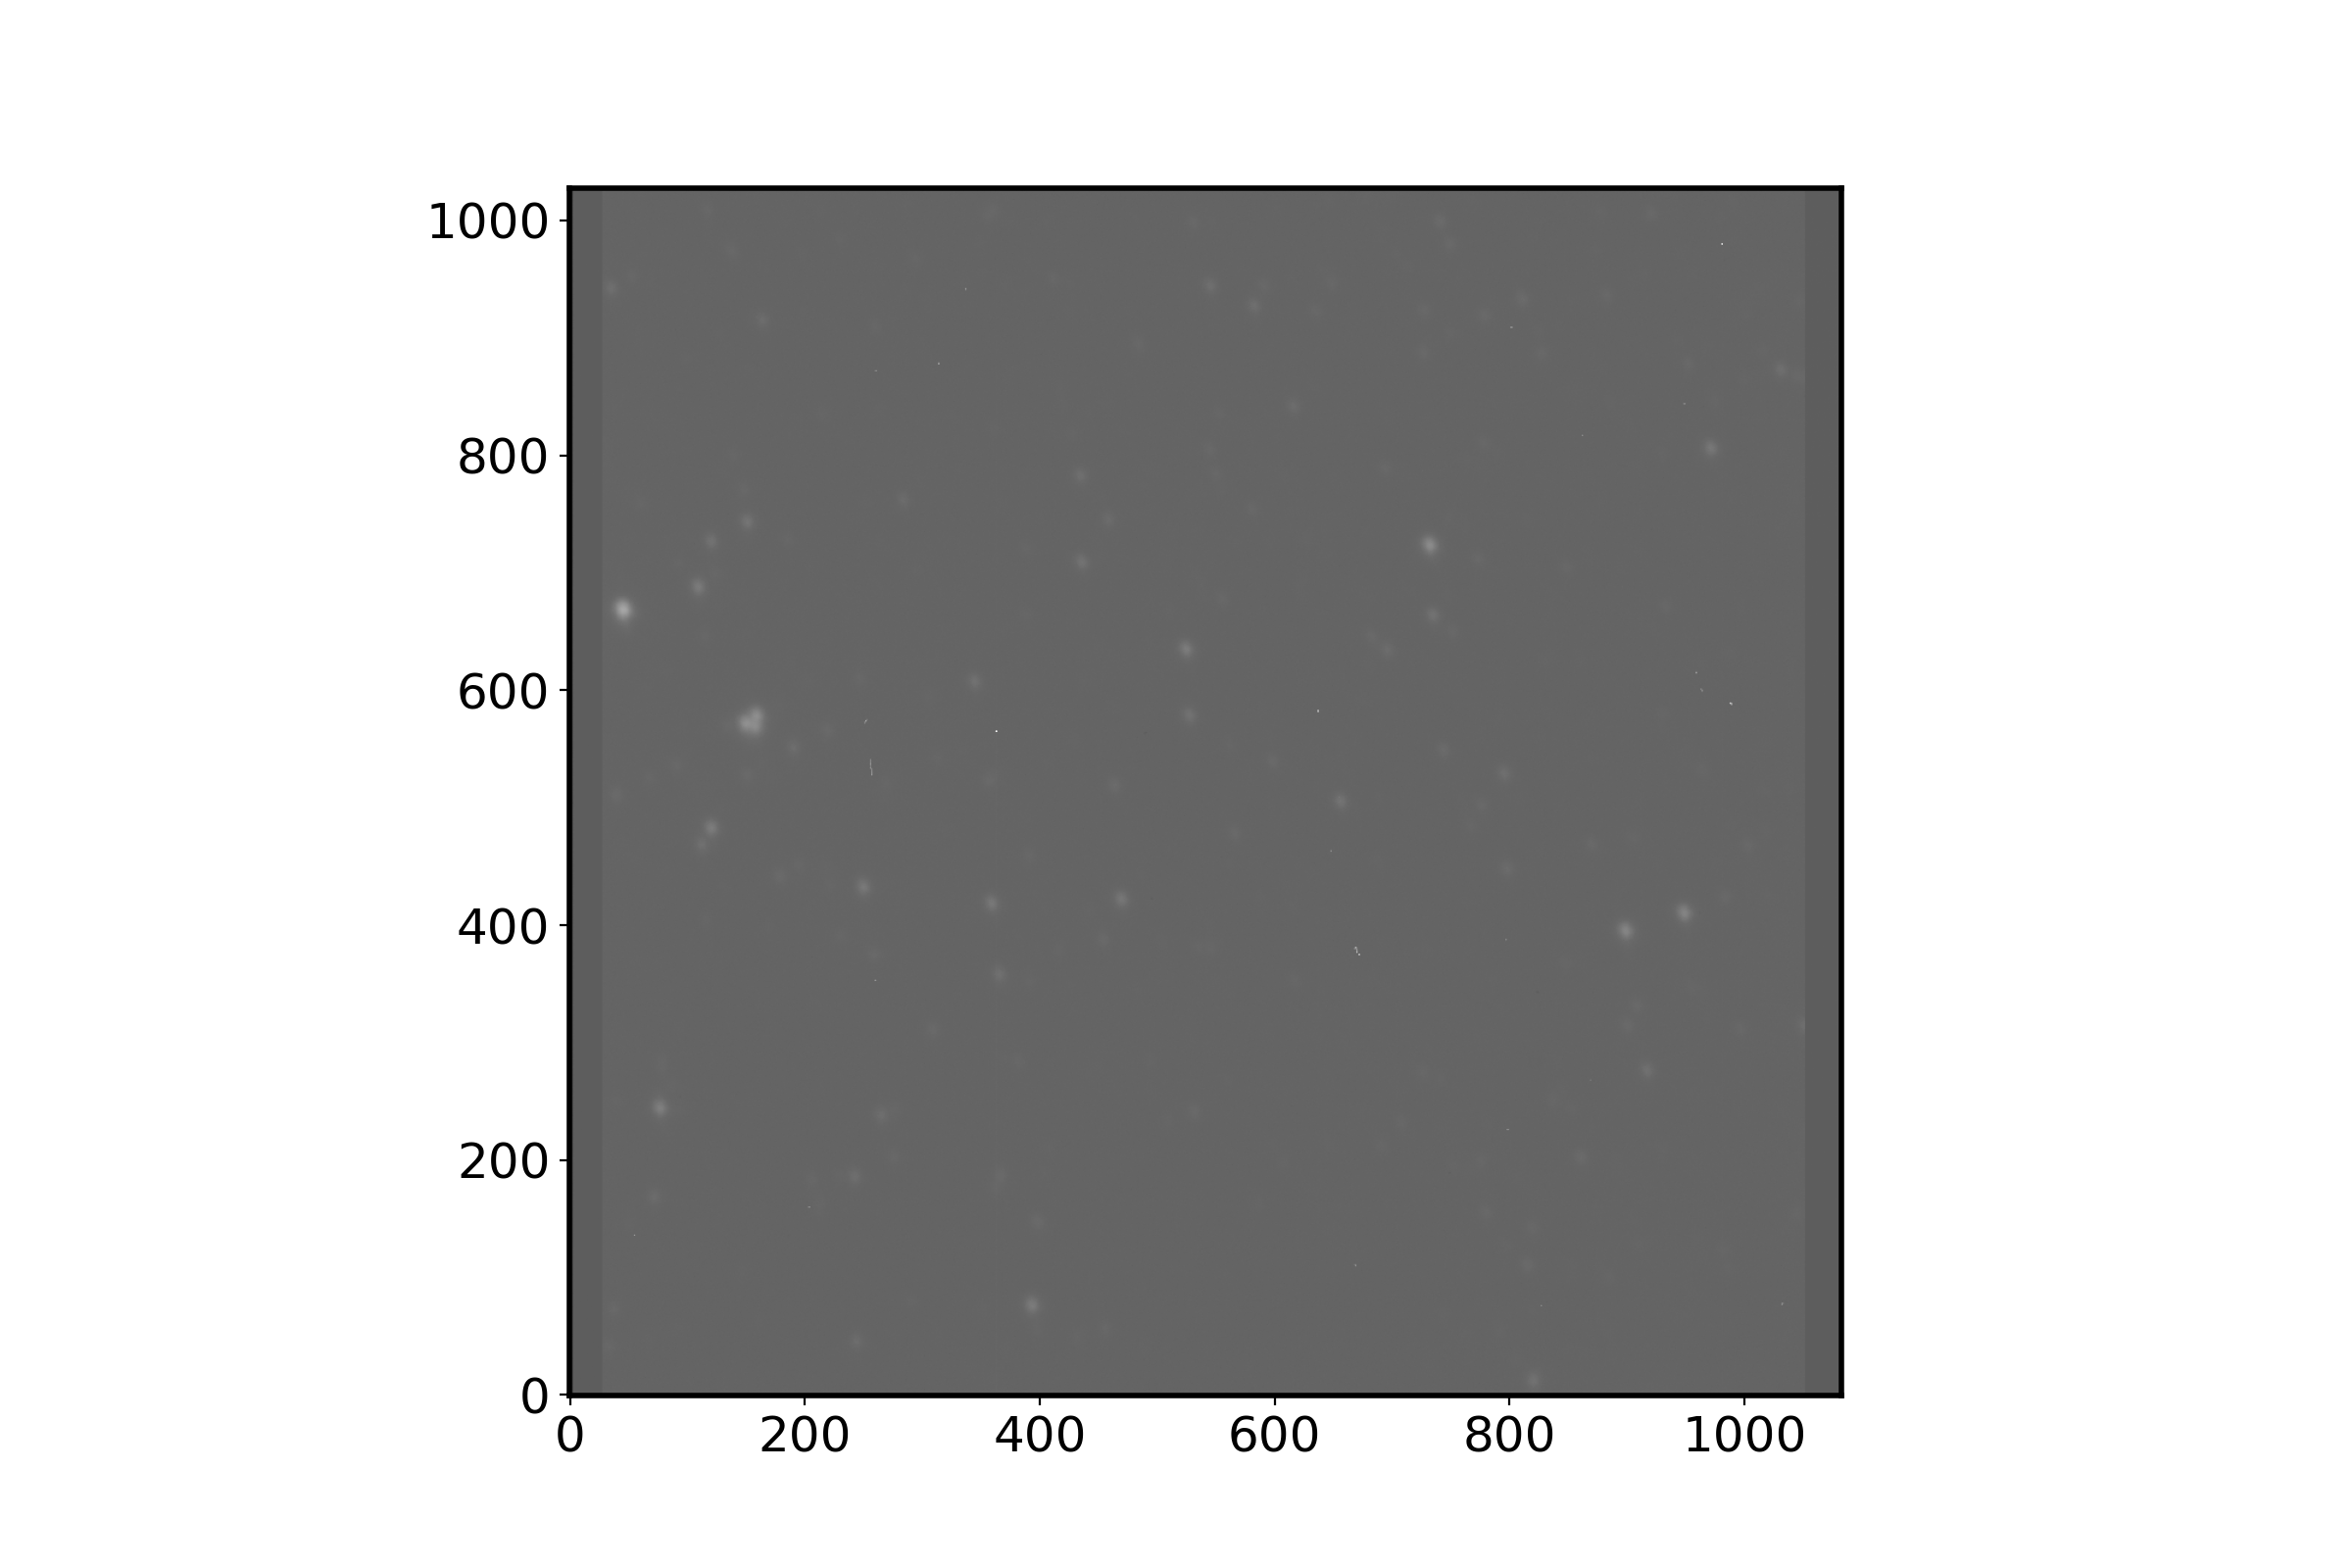

In [5]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot()

norm = simple_norm(ccd1, stretch='log')

ax1.imshow(ccd1.data,norm=norm,cmap='gray',origin='lower')

In [6]:
data_directory = "/Users/danakoeppe/Photometry_Practice/"

In [14]:
sfiles = ccdp.ImageFileCollection(sami_raw_data_path,ext=1)
sfiles.summary['file', 'filter1', 'filter2', 'exptime', 'naxis1','naxis2', 'obstype', 'biassec']


#obsra, obsdec = ccd1.header['ra'],ccd1.header['dec']



file,filter1,filter2,exptime,naxis1,naxis2,obstype,biassec
str26,str19,str17,float64,int64,int64,str6,str18
psa_171219_200003_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200009_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200016_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200022_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200029_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200035_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200042_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200049_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"
psa_171219_200055_zri.fits,s0027 SAM V-k-c-3x3,s9999 unavailable,0.0,1083,1028,ZERO,"[1053:1083,1:1028]"


In [8]:
calibrated_data = Path('/Users/danakoeppe/Photometry_Practice', 'example1-reduced')
calibrated_data.mkdir(exist_ok=True)

example_cryo_path = Path('/Users/danakoeppe/Photometry_Practice/example-cryo-LFC')
files = ccdp.ImageFileCollection(example_cryo_path)

files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str14,str9,str2,float64,int64,int64
ccd.001.0.fits,BIAS,i',0.0,2080,4128
ccd.002.0.fits,BIAS,i',0.0,2080,4128
ccd.003.0.fits,BIAS,i',0.0,2080,4128
ccd.004.0.fits,BIAS,i',0.0,2080,4128
ccd.005.0.fits,BIAS,i',0.0,2080,4128
ccd.006.0.fits,BIAS,i',0.0,2080,4128
ccd.014.0.fits,FLATFIELD,g',70.001,2080,4128
ccd.015.0.fits,FLATFIELD,g',70.011,2080,4128
ccd.016.0.fits,FLATFIELD,g',70.001,2080,4128


In [57]:
darks_only = ccdp.ImageFileCollection(example_cryo_path / 'darks')
darks_only.summary['file', 'imagetyp', 'exptime']


file,imagetyp,exptime
str14,str4,float64
ccd.002.0.fits,BIAS,0.0
ccd.013.0.fits,DARK,300.0
ccd.014.0.fits,DARK,300.0
ccd.015.0.fits,DARK,300.0
ccd.017.0.fits,DARK,70.0
ccd.018.0.fits,DARK,70.0
ccd.019.0.fits,DARK,70.0
ccd.023.0.fits,DARK,7.0
ccd.024.0.fits,DARK,7.0


In [17]:
files.summary['file', 'imagetyp', 'biassec', 'ccdsec', 'datasec'][0]

file,imagetyp,biassec,ccdsec,datasec
str14,str9,str18,str15,str15
ccd.001.0.fits,BIAS,"[2049:2080,1:4127]","[1:2048,1:4128]","[1:2048,1:4128]"


In [37]:
raw_biases = files.files_filtered(include_path=True, imagetyp='BIAS')
first_bias = CCDData.read(raw_biases[0], unit='adu')
bias_overscan_subtracted = ccdp.subtract_overscan(first_bias, overscan=first_bias[:, 2055:], median=True)
trimmed_bias1 = ccdp.trim_image(bias_overscan_subtracted,fits_section=bias_overscan_subtracted.header['datasec'])#[:, :2048])
trimmed_bias2 = ccdp.trim_image(bias_overscan_subtracted[:, :2048])


sami_raw_biases = sfiles.files_filtered(include_path=True, obstype='ZERO')
sami_first_bias = CCDData.read(sami_raw_biases[0], unit='adu',ext=1)
sami_bias_overscan_subtracted = ccdp.subtract_overscan(sami_first_bias, 
                                                       fits_section=sami_first_bias.header['biassec'], 
                                                       median=True)
sami_trimmed_bias = ccdp.trim_image(sami_bias_overscan_subtracted,
                                    fits_section=sami_bias_overscan_subtracted.header['trimsec'])


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


INFO:astropy:first HDU with data is extension 1.


In [86]:
palomar_calibrated_zeros_list = []
sami_calibrated_zeros_list = []
palomar_raw_zeros_list = []
for ccd, file_name in files.ccds(imagetyp='BIAS',            # Just get the bias frames
                                 ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
    
    palomar_raw_zeros_list.append(ccd)
        # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :2048])
    
    # Save the result
    ccd.write(calibrated_data / file_name, overwrite=True)
    
    palomar_calibrated_zeros_list.append(ccd)
    
    
for ccd, file_name in sfiles.ccds(obstype='ZERO',            # Just get the bias frames
                                 ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
        # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, fits_section=ccd.header['biassec'], median=True)
    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd,fits_section=ccd.header['trimsec'])
    
    # Save the result
    #ccd.write(calibrated_data / file_name)
    
    
    sami_calibrated_zeros_list.append(ccd)

In [87]:
#calibrated_path = Path('example1-reduced')
reduced_images = ccdp.ImageFileCollection(calibrated_data)

calibrated_biases = reduced_images.files_filtered(imagetyp='bias', include_path=True)

calibrated_biases

['/Users/danakoeppe/Photometry_Practice/example1-reduced/ccd.001.0.fits',
 '/Users/danakoeppe/Photometry_Practice/example1-reduced/ccd.002.0.fits',
 '/Users/danakoeppe/Photometry_Practice/example1-reduced/ccd.003.0.fits',
 '/Users/danakoeppe/Photometry_Practice/example1-reduced/ccd.004.0.fits',
 '/Users/danakoeppe/Photometry_Practice/example1-reduced/ccd.005.0.fits',
 '/Users/danakoeppe/Photometry_Practice/example1-reduced/ccd.006.0.fits',
 '/Users/danakoeppe/Photometry_Practice/example1-reduced/combined_bias.fit']

In [102]:

combined_bias = ccdp.combine(calibrated_biases,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

combined_bias.meta['combined'] = True

combined_bias.write(calibrated_data / 'combined_bias.fit', overwrite = True)

INFO: splitting each image into 5 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 5 chunks to limit memory usage to 350000000.0 bytes.


In [ ]:
fig2, (ax2_1, ax2_2) = plt.subplots(1, 2, figsize=(12, 10))

show_image(palomar_calibrated_zeros_list[0].data, cmap='gray', ax=ax2_1, fig=fig2)
ax2_1.set_title('Single calibrated bias')
show_image(combined_bias.data, cmap='gray', ax=ax2_2, fig=fig2, percl=90)

ax2_2.set_title('{} bias images combined'.format(len(calibrated_biases)))



<IPython.core.display.Javascript object>


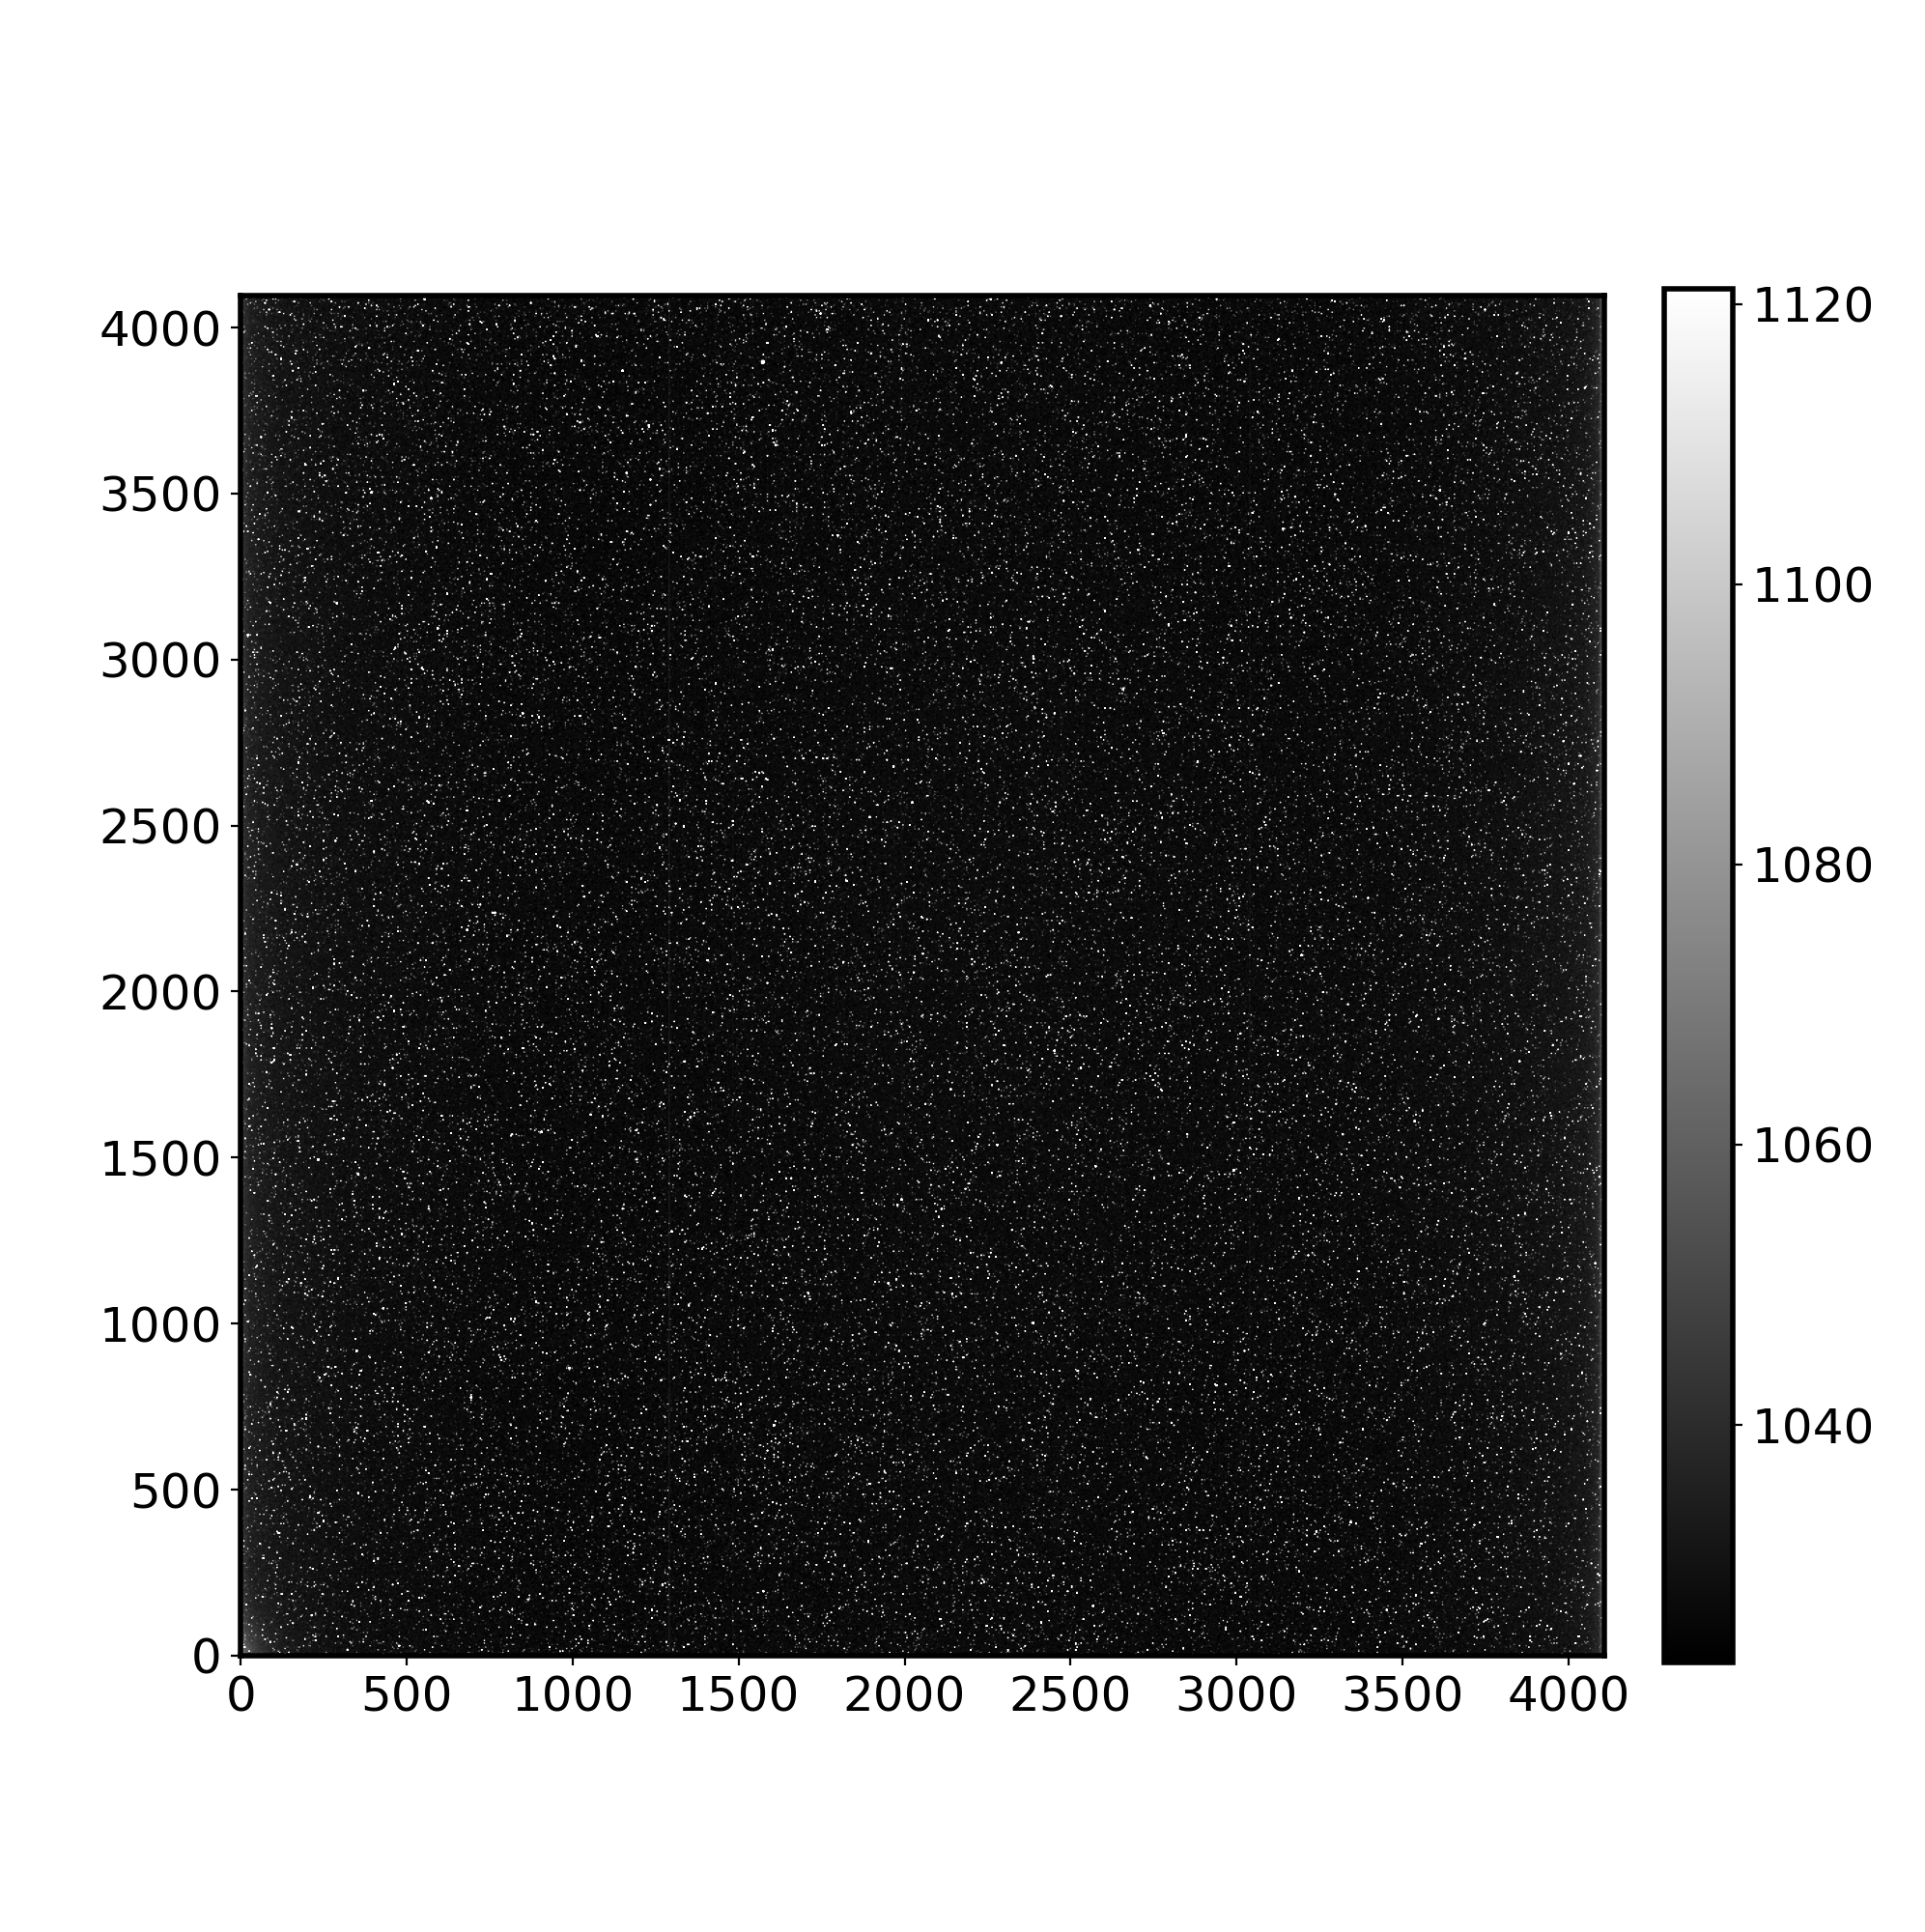

In [100]:
calibrated_images = Path('/Users/danakoeppe/Photometry_Practice/')
combined_dark_lfc = CCDData.read(calibrated_images / 'combined_dark_300.000.fits.bz2')


dark_1000 = CCDData.read(calibrated_images / 'dark-test-0002d1000.fit.bz2', unit = 'adu')

show_image(dark_1000, cmap='gray')

In [95]:
bias_stds = []


for i in range(len(palomar_calibrated_zeros_list)):
    
    
    main_bias = palomar_calibrated_zeros_list[i]
    stds = [np.std(main_bias.data - sub_bias.data)/np.sqrt(2) for sub_bias in palomar_calibrated_zeros_list[i+1:] \
             if i<len(palomar_calibrated_zeros_list)-1]
    
    means = [np.mean(main_bias.data - sub_bias.data) for sub_bias in palomar_calibrated_zeros_list[i+1:] \
             if i<len(palomar_calibrated_zeros_list)-1]
    #print(stds)
    #print(means)
    bias_stds.extend(stds)

    
np.asarray(bias_stds)*1.1

array([6.40306786, 6.1873414 , 5.91384113, 5.92690482, 6.06256794,
       6.83363061, 6.5281733 , 6.54237685, 6.66981437, 6.30687787,
       6.30124647, 6.43761716, 6.01940375, 6.1572686 , 6.16987361])

In [79]:
palomar_calibrated_zeros_list[0].header

SIMPLE  =                    T  / STANDARD FITS                                 
BITPIX  =                   16  / BITS/PIXEL                                    
NAXIS   =                    2  / NUMBER OF AXES                                
NAXIS1  =                 2080  / NUMBER OF COLUMNS                             
NAXIS2  =                 4128  / NUMBER OF ROWS                                
BSCALE  =        1.0000000E+00  / PHYSICAL = BSCALE * DATA + BZERO              
BZERO   =               32768.                                                  
DATE    = '2016-01-15'          / UT Date of file creation (DD/MM/YY)           
ORIGIN  = 'California Institute of Technology'  / Palomar Observatory           
LATITUDE=              33.4000  / Latitude (degrees N)                          
LONGITUD=            -116.9000  / Longitude (degrees E)                         
TELESCOP= 'Hale 5m Telescope'   / Telescope used for observation                
FRATIO  =               7.50

In [103]:
dark_1000.header

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4109 /fastest changing axis                           
NAXIS2  =                 4096 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2018-05-31T23:31:43' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   1000.0000000000000 /Exposure time in seconds                        
EXPOSURE=   1000.0000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.044505250000000 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

<IPython.core.display.Javascript object>


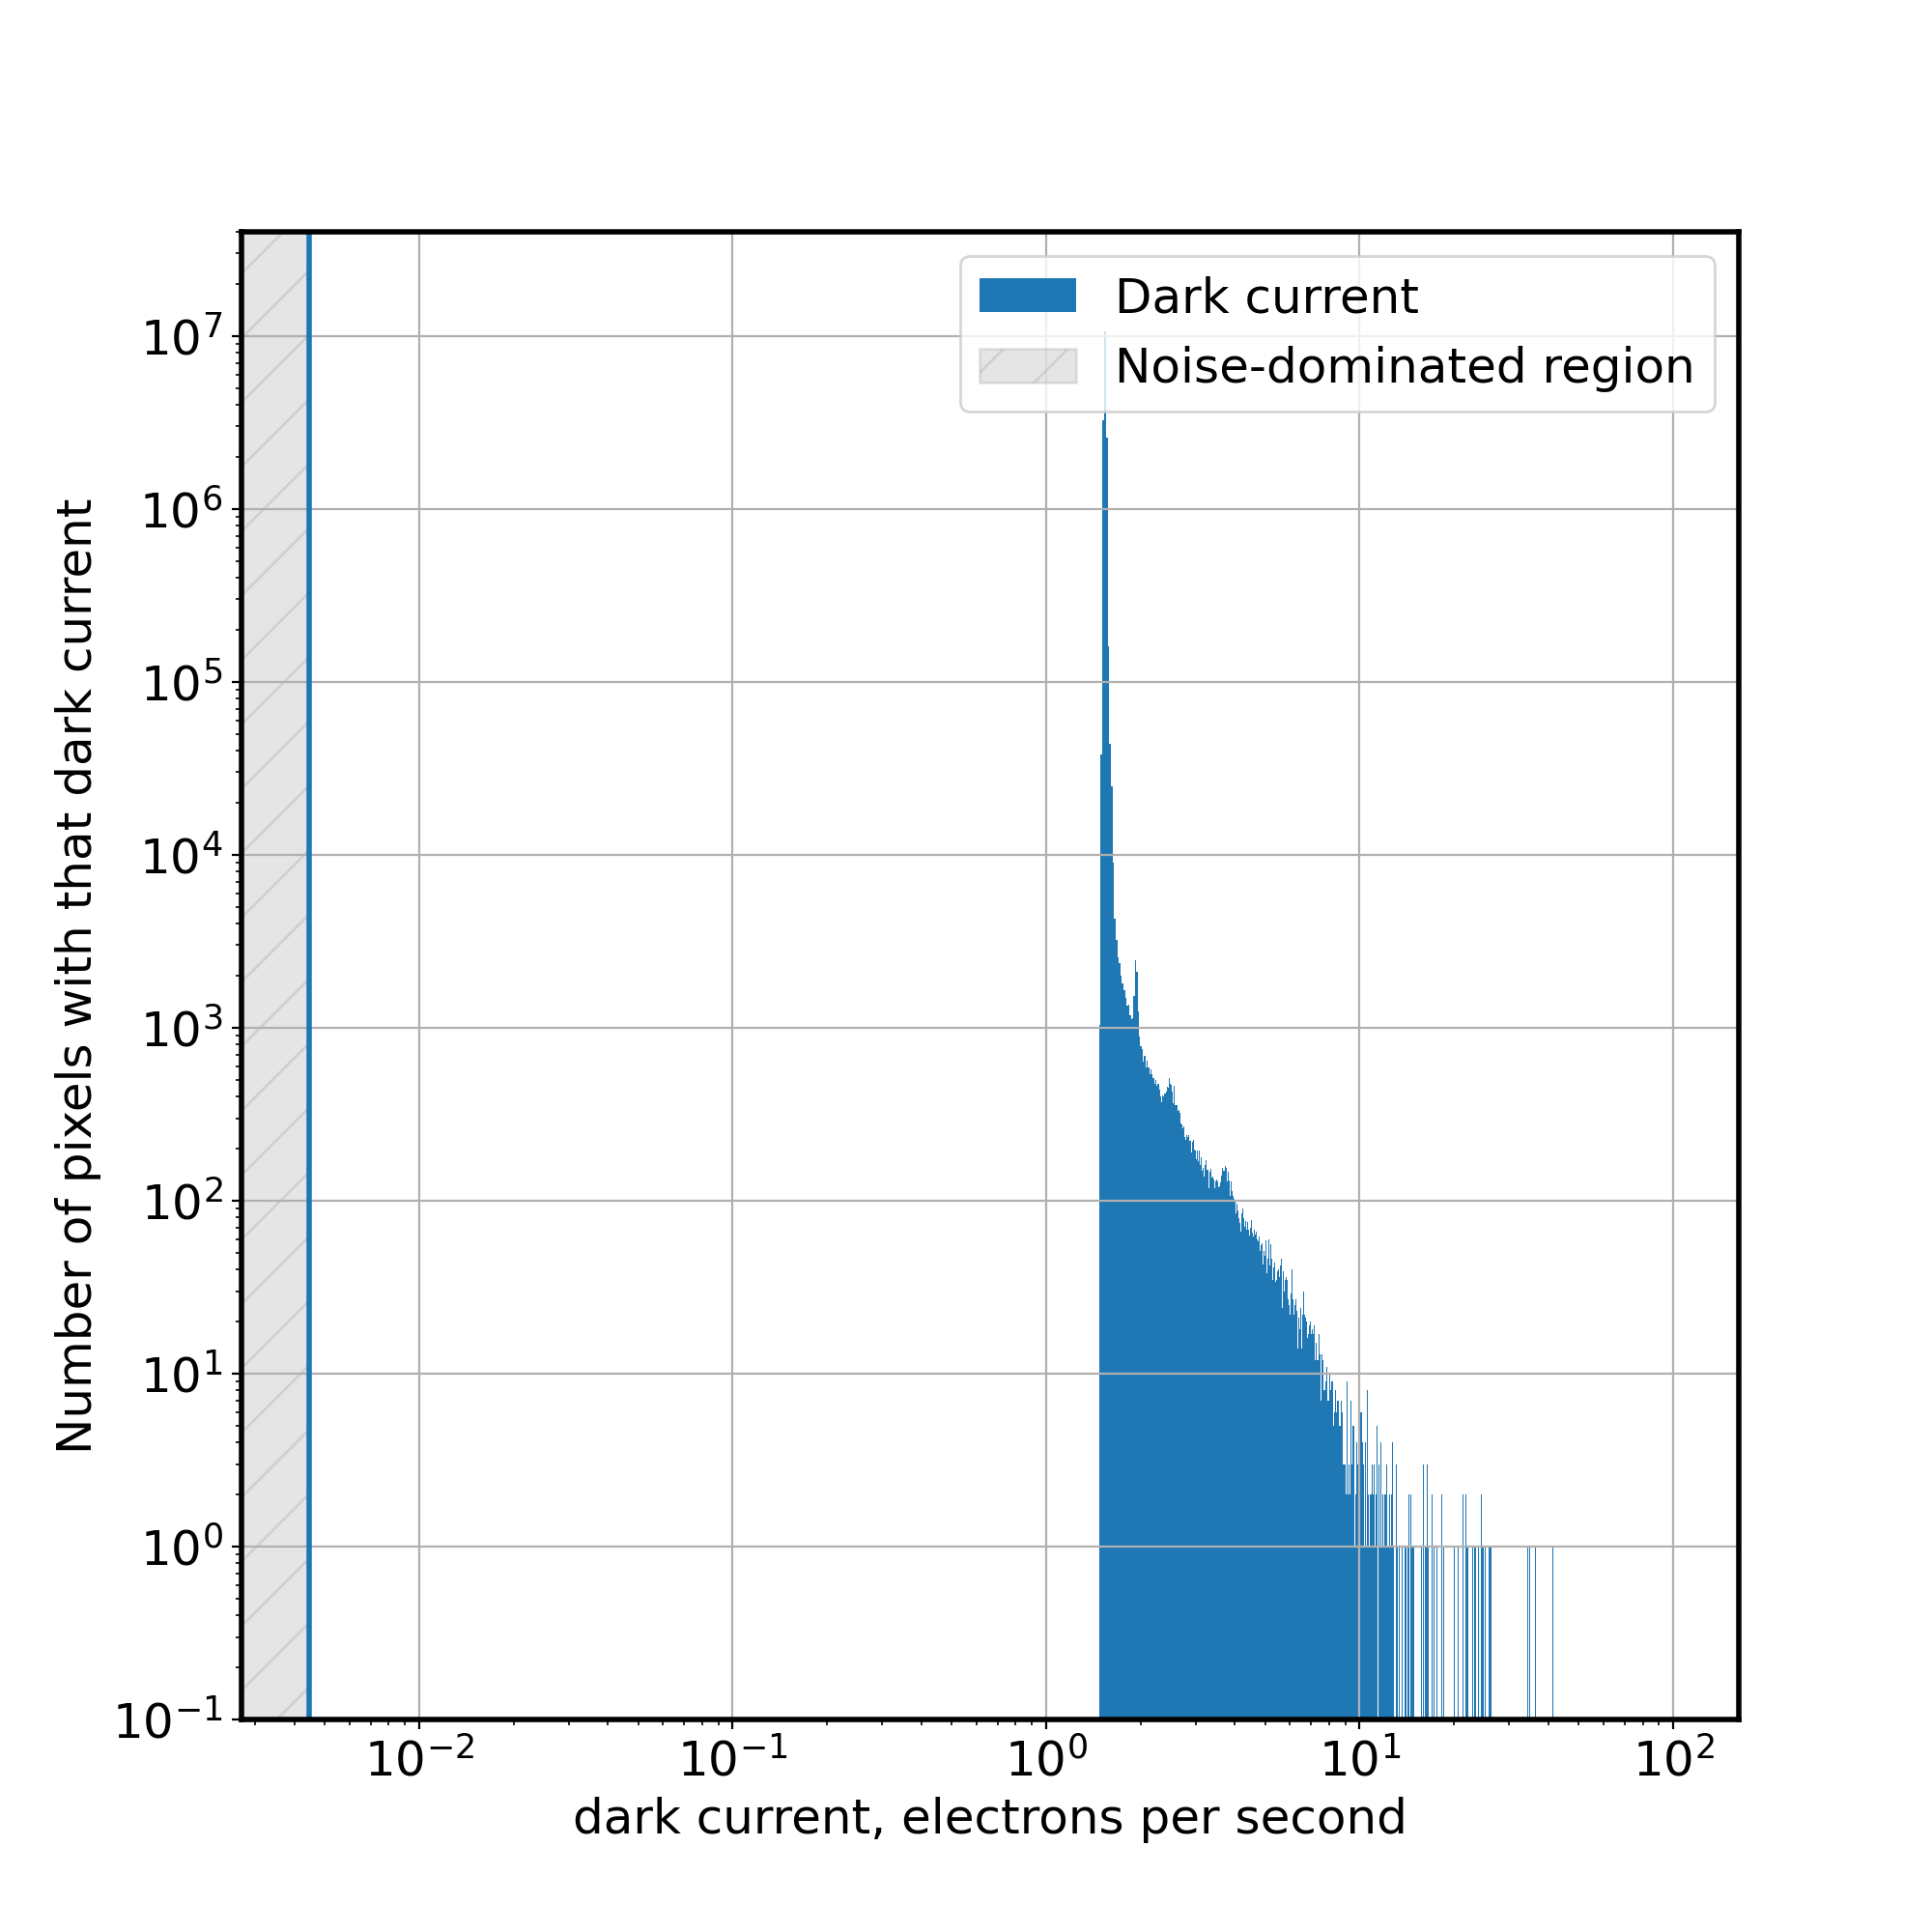

In [105]:
gain = 1.5
read_noise = 10.0
exposure_time = 1000

dark_current = gain * dark_1000.data / exposure_time

noisy_region = 2 * read_noise / exposure_time / np.sqrt(20)

plt.figure(figsize=(10, 10))
hist(dark_current.flatten(), bins=5000, density=False, label='Dark current');

plt.ylim(0.1, 4e7)
plt.vlines(noisy_region, *plt.ylim())

plt.loglog()
plt.grid()


x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
noisy_region = plt.Rectangle((x_min, y_min), noisy_region - x_min, y_max - y_min, label='Noise-dominated region',
                             color='gray', alpha=0.2, hatch='/')
ax4 = plt.gca()
ax4.add_patch(noisy_region)

plt.legend()

plt.xlabel('dark current, electrons per second')
plt.ylabel('Number of pixels with that dark current');